## Read before making template
### For the making tmplate v3, it main has three missions:  
1. make clean template for K_/alpha, which has amplitude above 11k,
2. make clean template for K_/beta, which has amplitude below 11k,
3. And for the PSD, chossing noise from 30%:80%
 - As benedikt point out, making templates should apply some hard cuts, to choose clean traces for make templates.  
 - The shape of the template should be (n, 32768), currently is (2, 32768) for the fitting in the module named fit_results.py and optimum_filter for the uv and qp seperately.
 - Template need to be normalized to [0, 1]
 - Remeber to smooth out the template
 - Fitting mainly done in the fit_result module.  
 - Whan making template, go to default.py change the shift to (0, 0) to make sure the events for making templates have the length of 32768. But need to change back to (-200, 200) to make sure fitting succeed
## TODOs
 - change the length of each event into 32768
 - get all 100 raw traces into helix events and save raw into csv,
 - Apply some hard cut-offs to traces, get first level pass rate
 - Discreminate the rest traces into Ka and Kb
 - Clean traces and make the corresponding templates

In [1]:
import numpy as np
import strax
import helix as hx
import strax as sx                    
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter, medfilt



run_id = 'run10' 
duration = 10  # seconds
raw_data_dir = 'toy_data'  # to save the raw toy data
helix_data_dir = 'test_helix_data'  # to save the run metadata
context = sx.Context(storage=[sx.DataDirectory(helix_data_dir, provide_run_metadata=True), ],
                     register=[hx.MMCRecords,
                               hx.QPTriggers, hx.UVTriggers,
                               hx.Events, hx.NoiseEvents,
                               hx.NoisePSDs, hx.FitResults])    # all the plugins required for getting fit_results

# creating a dictionary of plugins' options that we want to modify. 
config = {'run_metadata_directory': helix_data_dir,      # for the hx.ToyDataRawRecords plugin
          'noise_events_random_seed': 0}  # for the hx.NoiseEvents plugin

context.set_config(config)
events = context.get_array(run_id, 'events')

raw_data = events['channel_data']
raw_data.shape

Loading events: |                   | 0.00 % [00:00<?], #1 (0.05 s). 2660.0 MB/s


(9, 50, 33168)

In [3]:
indices_to_remove = np.array([4, 2])
channel0_data_excl = np.delete(raw_data[:, 0, :], indices_to_remove, axis=0)

# Apply Savitzky-Golay filter to smooth traces (vectorized operation)
processed_traces = savgol_filter(channel0_data_excl, window_length=51, polyorder=3, axis=1)

# Compute Mean Template & Apply Median Filtering
filtered_template = medfilt(np.mean(processed_traces, axis=0), kernel_size=81)

# Normalize to [0, 1] (vectorized)
normalized_template = (filtered_template - filtered_template.min()) / (filtered_template.ptp())

In [4]:
if normalized_template.ndim == 1:
     normalized_template = normalized_template.reshape(1, -1)
elif normalized_template.shape[0] != 1:
    raise ValueError("Input array must have shape (L,) or (1, L)")
    
duplicated_array = np.vstack([normalized_template, normalized_template])
np.save("2level2_template.npy", duplicated_array)

Template Length: 32768
Template Min: 0.000000
Template Max: 1.000000
Template Mean: 0.461809


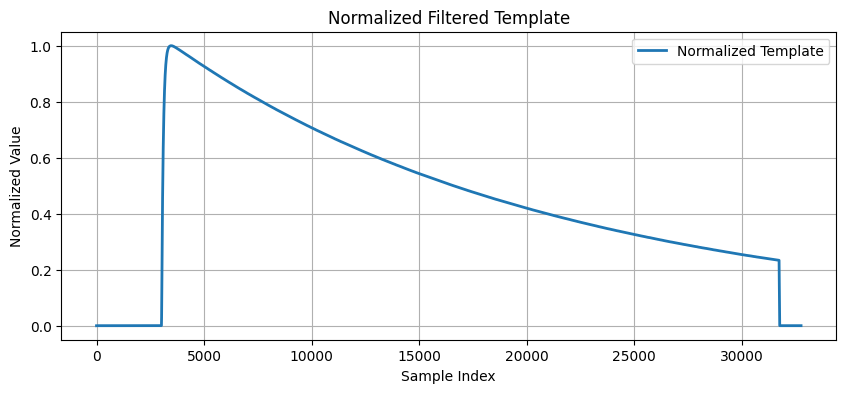

In [10]:
normalized_template = normalized_template[0]
template_length = len(normalized_template)
template_min = np.min(normalized_template)
template_max = np.max(normalized_template)
template_mean = np.mean(normalized_template)

print(f"Template Length: {template_length}")
print(f"Template Min: {template_min:.6f}")
print(f"Template Max: {template_max:.6f}")
print(f"Template Mean: {template_mean:.6f}")

# Plot the normalized template
plt.figure(figsize=(10, 4))
plt.plot(normalized_template, label="Normalized Template", linewidth=2)
plt.xlabel("Sample Index")
plt.ylabel("Normalized Value")
plt.title("Normalized Filtered Template")
plt.legend()
plt.grid()
plt.show()